In [40]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


import numpy as np
import re
import io
import time

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpu = gpus[0]
tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping 

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D, SimpleRNN, LSTM, GRU

In [3]:
import zipfile
with zipfile.ZipFile('D:/GeekBrains/nlp/les10/rus-eng.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [4]:
path_to_file = "rus.txt"

In [5]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w) #collapse whitespaces

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip() #Remove spaces at the beginning and at the end of the string

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [7]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [8]:
len(en), len(ru)

(431097, 431097)

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
#     targ_lang, inp_lang = create_dataset(path, num_examples) # ru -> en
    targ_lang, inp_lang = create_dataset(path, num_examples) # en -> ru
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
# Try experimenting with the size of that dataset
# num_examples = len(en)
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [12]:
max_length_targ, max_length_inp

(12, 15)

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

120000 120000 30000 30000


In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
convert(inp_lang, input_tensor_train[0])

1 ----> <start>
10 ----> ты
23 ----> был
120 ----> дома
5 ----> ?
2 ----> <end>


In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128

steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 15]), TensorShape([128, 12]))

#### model

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True, #additional output dim sequence length
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')


    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state # нужен выходной слой

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 15, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [20]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query - sample_hidden
        # values - sample_output
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        # W1 - sample_hidden через Dense
        # W2 - sample_output через Dense
        # tanh активация -> скоры
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [21]:
attention_layer = BahdanauAttention(10) # 10 юнитов - гиперпараметр?
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 15, 1)


In [22]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)        

    def call(self, x, hidden, enc_output): # подаем еще и выходной слой
        # enc_output shape == (batch_size, max_length, hidden_size) = (batch size, sequence length, units)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # конкатим с вектором контекста из внимания

        # passing the concatenated vector to the GRU
        output, state = self.gru(x, initial_state=hidden) 
        #initial_state = sample_hidden - List of initial state tensors to be passed to the first call of the cell

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
decoder_sample_x, decoder_sample_h, decoder_sample_w = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
decoder_sample_x.shape # (batch_size, vocab size)

TensorShape([128, 8879])

In [24]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [25]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [26]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, att_weights = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [27]:
# EPOCHS = 50

# for epoch in range(EPOCHS):
#     start = time.time()

#     enc_hidden = encoder.initialize_hidden_state()
#     total_loss = 0

#     for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
#         batch_loss = train_step(inp, targ, enc_hidden)
#         total_loss += batch_loss

#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
#                                                        batch,
#                                                        batch_loss.numpy()))
#     # saving (checkpoint) the model every 2 epochs
#     if (epoch + 1) % 10 == 0:
#         checkpoint.save(file_prefix = checkpoint_prefix)

#     print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
#     print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5157
Epoch 1 Batch 100 Loss 2.0965
Epoch 1 Batch 200 Loss 1.7331
Epoch 1 Batch 300 Loss 1.5394
Epoch 1 Batch 400 Loss 1.3045
Epoch 1 Batch 500 Loss 1.1621
Epoch 1 Batch 600 Loss 1.0295
Epoch 1 Batch 700 Loss 0.9889
Epoch 1 Batch 800 Loss 0.8724
Epoch 1 Batch 900 Loss 0.7901
Epoch 1 Loss 1.3568
Time taken for 1 epoch 327.4585852622986 sec

Epoch 2 Batch 0 Loss 0.6048
Epoch 2 Batch 100 Loss 0.6490
Epoch 2 Batch 200 Loss 0.5676
Epoch 2 Batch 300 Loss 0.4955
Epoch 2 Batch 400 Loss 0.5667
Epoch 2 Batch 500 Loss 0.5100
Epoch 2 Batch 600 Loss 0.5276
Epoch 2 Batch 700 Loss 0.4360
Epoch 2 Batch 800 Loss 0.4847
Epoch 2 Batch 900 Loss 0.4632
Epoch 2 Loss 0.5306
Time taken for 1 epoch 320.1566617488861 sec

Epoch 3 Batch 0 Loss 0.2599
Epoch 3 Batch 100 Loss 0.2416
Epoch 3 Batch 200 Loss 0.2876
Epoch 3 Batch 300 Loss 0.2817
Epoch 3 Batch 400 Loss 0.2688
Epoch 3 Batch 500 Loss 0.3048
Epoch 3 Batch 600 Loss 0.2523
Epoch 3 Batch 700 Loss 0.2796
Epoch 3 Batch 800 Loss 0.3040
Epoc

Epoch 23 Batch 200 Loss 0.0683
Epoch 23 Batch 300 Loss 0.0465
Epoch 23 Batch 400 Loss 0.0710
Epoch 23 Batch 500 Loss 0.0685
Epoch 23 Batch 600 Loss 0.0885
Epoch 23 Batch 700 Loss 0.0809
Epoch 23 Batch 800 Loss 0.1029
Epoch 23 Batch 900 Loss 0.0870
Epoch 23 Loss 0.0718
Time taken for 1 epoch 317.91442227363586 sec

Epoch 24 Batch 0 Loss 0.0606
Epoch 24 Batch 100 Loss 0.0601
Epoch 24 Batch 200 Loss 0.0678
Epoch 24 Batch 300 Loss 0.0492
Epoch 24 Batch 400 Loss 0.0587
Epoch 24 Batch 500 Loss 0.0744
Epoch 24 Batch 600 Loss 0.0850
Epoch 24 Batch 700 Loss 0.1035
Epoch 24 Batch 800 Loss 0.0675
Epoch 24 Batch 900 Loss 0.0932
Epoch 24 Loss 0.0710
Time taken for 1 epoch 317.77482557296753 sec

Epoch 25 Batch 0 Loss 0.0675
Epoch 25 Batch 100 Loss 0.0886
Epoch 25 Batch 200 Loss 0.0631
Epoch 25 Batch 300 Loss 0.0653
Epoch 25 Batch 400 Loss 0.0674
Epoch 25 Batch 500 Loss 0.0825
Epoch 25 Batch 600 Loss 0.0778
Epoch 25 Batch 700 Loss 0.0877
Epoch 25 Batch 800 Loss 0.0869
Epoch 25 Batch 900 Loss 0.0676


Epoch 45 Batch 0 Loss 0.0477
Epoch 45 Batch 100 Loss 0.0521
Epoch 45 Batch 200 Loss 0.0832
Epoch 45 Batch 300 Loss 0.0742
Epoch 45 Batch 400 Loss 0.0879
Epoch 45 Batch 500 Loss 0.0456
Epoch 45 Batch 600 Loss 0.0890
Epoch 45 Batch 700 Loss 0.0866
Epoch 45 Batch 800 Loss 0.0767
Epoch 45 Batch 900 Loss 0.0617
Epoch 45 Loss 0.0681
Time taken for 1 epoch 324.73681116104126 sec

Epoch 46 Batch 0 Loss 0.0419
Epoch 46 Batch 100 Loss 0.0810
Epoch 46 Batch 200 Loss 0.0675
Epoch 46 Batch 300 Loss 0.0448
Epoch 46 Batch 400 Loss 0.0573
Epoch 46 Batch 500 Loss 0.0428
Epoch 46 Batch 600 Loss 0.1112
Epoch 46 Batch 700 Loss 0.0754
Epoch 46 Batch 800 Loss 0.0690
Epoch 46 Batch 900 Loss 0.0941
Epoch 46 Loss 0.0683
Time taken for 1 epoch 322.28126096725464 sec

Epoch 47 Batch 0 Loss 0.0503
Epoch 47 Batch 100 Loss 0.0834
Epoch 47 Batch 200 Loss 0.0525
Epoch 47 Batch 300 Loss 0.0551
Epoch 47 Batch 400 Loss 0.0537
Epoch 47 Batch 500 Loss 0.0627
Epoch 47 Batch 600 Loss 0.0893
Epoch 47 Batch 700 Loss 0.0857
Ep

#### translate

In [32]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()        
           
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [36]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [37]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))    

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> началось все с котов . <end>
Predicted translation: everyone day hated . <end> 


C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


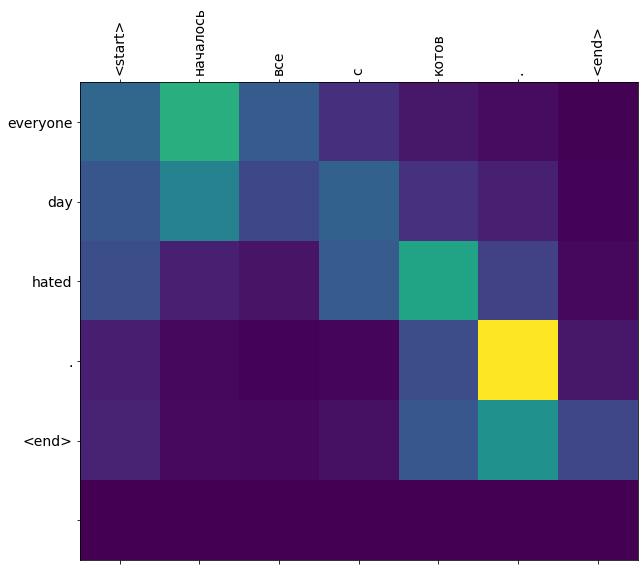

In [41]:
translate('Началось все с котов.')

Input: <start> нужно бежать со всех ног <end>
Predicted translation: how often are your full ? <end> 


C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


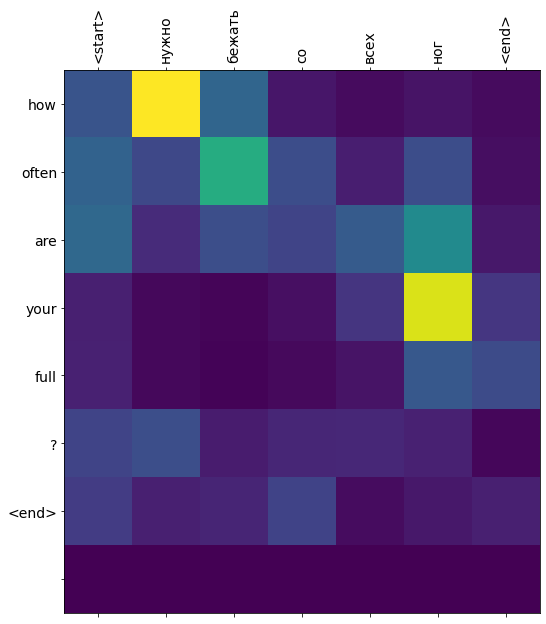

In [42]:
translate('Нужно бежать со всех ног')

Input: <start> нужно бежать со всех ног , чтобы только оставаться на месте , а чтобы куда то попасть , надо бежать как минимум вдвое быстрее <end>
Predicted translation: where is going to go , too . <end> 


C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


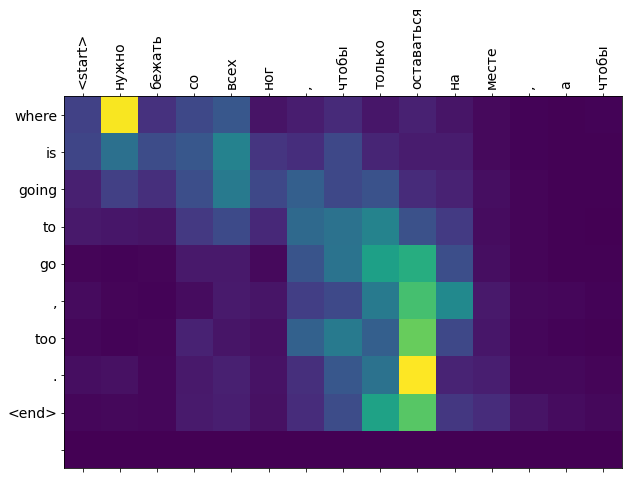

In [43]:
translate('Нужно бежать со всех ног, чтобы только оставаться на месте, а чтобы куда-то попасть, надо бежать как минимум вдвое быстрее')

Полученный перевод и здесь не соответствует действительности